### [Regression Data Analysis]
# KaKR House Price Prediction - Boost Models Scoring Comparison

- 지금까지 이루어진 전처리 및 feature engineering을 함수로 합쳐서 한 번에 처리합니다.


- scoring을 위한 여러 함수도 생성해 놓은 후 반복적으로 사용하며 점수를 비교합니다.


- 데이터셋을 이용하여 Boosting 기반 여러가지 모델을 통해 각 feature의 유효성을 확인합니다.


- 각 모델별로도 비교하여 어떤 모델이 좋은지 확인합니다.

---

#### Import Modules

In [1]:
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import skew

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Data Load

In [7]:
row_data = pd.read_csv("./data/train.csv", index_col=['id'])
row_test = pd.read_csv("./data/test.csv", index_col=['id'])

row_data.shape, row_test.shape

((15035, 20), (6468, 19))

---

# Utility Functions

## Features Preprocessing function

- data에 지금까지 생성해본 feature들을 한 번에 전처리 해주는 함수

In [8]:
def feature_preprocess(row_data, zipcode_rank_dict):
    
    data = row_data.copy()
    
    # price log transformation
    if 'price' in data.columns:
        data['log_price'] = np.log1p(data.price)
    
    # Date parsing
    data['date'] = data['date'].apply(lambda i: i[:8])
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['day']= data.date.dt.day
    data['year_month'] = data.date.dt.year * 100 + data.date.dt.month
    data['day_of_week'] = data.date.dt.dayofweek
    data['2015_or_not'] = data.year.apply(lambda i: 0 if i == 2014 else 1)
    data['weekday_ohe'] = data.day_of_week.apply(lambda i: 1 if i in range(5) else 0)
    data['saturday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 5 else 0)
    data['sunday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 6 else 0)
    
    # yr_renovated
    data['yr_renovated_ohe'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)
    
    # zipcode : 위에서 zipcode_rank_dict를 만들어놔야 코드가 실행됨
    data['zipcode_rank'] = 71 - data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
    
    # lat / long
    data['lat_scale'] = (data['lat'] - data['lat'].mean()) / data['lat'].std()
    data['long_scale'] = (data['long'] - data['long'].mean()) / data['long'].std()
    
    # areas
    data['sqft_living_scale'] = np.log1p(data['sqft_living'])
    data['sqft_lot_scale'] = np.log1p(data['sqft_lot'])
    data['sqft_living_diff'] = data['sqft_living15'] - data['sqft_living']
    data['sqft_lot_diff'] = data['sqft_lot15'] - data['sqft_lot']
    data.loc[data['sqft_living_diff'] < 0, 'sqft_living_diff_scale'] = -np.log1p(-data['sqft_living_diff'])
    data.loc[data['sqft_living_diff'] >= 0, 'sqft_living_diff_scale'] = np.log1p(data['sqft_living_diff'])
    data.loc[data['sqft_lot_diff'] < 0, 'sqft_lot_diff_scale'] = -np.log1p(-data['sqft_lot_diff'])
    data.loc[data['sqft_lot_diff'] >= 0, 'sqft_lot_diff_scale'] = np.log1p(data['sqft_lot_diff'])
    data['sqft_above_scale'] = np.log1p(data['sqft_above'])
    data['sqft_basement_ohe'] = data.sqft_basement.apply(lambda i: 0 if i == 0 else 1)
    
    return data

- `zipcode_rank` 컬럼을 생성하기 위한 zipcode_rank를 담은 딕셔너리 생성 함수

In [9]:
def get_ziprank(data):
    zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                                ascending=False).reset_index()[['zipcode', 'price']]
    zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
    zipcode_rank_dict = zipcode_rank.set_index(['zipcode'])['rank'].to_dict()
    
    return zipcode_rank_dict

In [10]:
zipcode_rank_dict = get_ziprank(row_data)
pd.DataFrame(zipcode_rank_dict, index=['rank']).T.head(10)

,rank
98039,1
98004,2
98040,3
98112,4
98102,5
98109,6
98105,7
98119,8
98006,9
98199,10


- `row_data`에 feature_preprocess 함수를 통해 여러가지 컬럼을 한 번에 생성

In [11]:
data = feature_preprocess(row_data, zipcode_rank_dict)
test = feature_preprocess(row_test, zipcode_rank_dict)

data.shape, test.shape

((15035, 42), (6468, 40))

In [12]:
set(data.columns) - set(test.columns)

{'log_price', 'price'}

## Evaluation functions

- `RMSLE`, `RMSE`, `R2` 점수 등을 계산하는 함수

In [17]:
def rmsle_cv(model, train, label):
    rmse_list = np.sqrt(-cross_val_score(model, train, label, scoring='neg_mean_squared_error', cv=5))
#     print("{} RMSE lists: {}".format(model.__class__.__name__, np.round(rmse_list, 4)))
#     print("[{}] RMSE average: {}".format(model.__class__.__name__, np.round(np.mean(rmse_list), 4)))
    
    return np.round(np.mean(rmse_list), 4)

In [18]:
def r2_cv(model, train, label):
    r2_list = cross_val_score(model, train, label, scoring='r2', cv=5)
#     print("{} RMSE lists: {}".format(model.__class__.__name__, np.round(r2_list, 4)))
#     print("[{}] r2_score average: {}".format(model.__class__.__name__, np.round(np.mean(r2_list), 4)))
    
    return np.round(np.mean(r2_list), 4)

In [19]:
def rmse(model, y_test, y_pred):
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
#     print("[{}] rmse: {}".format(model.__class__.__name__, np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)))
    
    return np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))

- 위의 세 가지 점수를 한 번에 출력해주는 함수

In [20]:
def get_scores(models, train, label, rmse_=True):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        df[model_name] = []
        df[model_name].append(rmsle_cv(model, train, label))
        df[model_name].append(r2_cv(model, train, label))
        
        if rmse_:
            X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            df[model_name].append(rmse(model, y_test, y_pred))
        
        if rmse_:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score', 'RMSE']).T.sort_values('R2 score', \
                                                                                           ascending=False)
        else:
            score_df = pd.DataFrame(df, index=['RMSLE', 'R2 score']).T.sort_values('R2 score', \
                                                                                   ascending=False)
            
    return score_df

## Coefficient

- Linear 모델에서 계수를 확인할 수 있게 해주는 함수

In [2]:
def get_coef(models, sort_model):
    coef = {}
    
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        coef[model_name] = model.coef_
    
    else:
        for model in models:
            model_name = model.__class__.__name__
            coef[model_name] = model.coef_

    coef_df = pd.DataFrame(coef, index=train.columns)
    
    return coef_df.sort_values(sort_model.__class__.__name__, ascending=False)

- 회귀계수 시각화 함수

In [4]:
def draw_coefs(models):
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        sns.barplot(x=get_coef(models, model)[model_name].values, \
                    y=get_coef(models, model)[model_name].index).set_title(model_name)
            
    elif len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx]).set_title(model_name)
    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            sns.barplot(x=get_coef(models, model)[model_name].values, \
                        y=get_coef(models, model)[model_name].index, \
                        ax=axs[idx//2][idx%2]).set_title(model_name)
    
    plt.show()

- Boosting 모델의 feature importance 시각화 함수

In [22]:
def draw_importances(models, data):
    if type(models) != list:
        model = models
        model_name = model.__class__.__name__
        importances = [i for i in zip(data.columns, model.feature_importances_)]
        importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
        plt.figure(figsize=(8, 6))
        sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances]).set_title(model_name)
    
    elif len(models) == 3:
        figure, axs = plt.subplots(nrows=1, ncols=3)
        figure.set_size_inches(18, 6)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx]).set_title(model_name)

    else:
        figure, axs = plt.subplots(nrows=2, ncols=2)
        figure.set_size_inches(18, 12)

        for idx, model in enumerate(models):
            model_name = model.__class__.__name__
            importances = [i for i in zip(train.columns, model.feature_importances_)]
            importances = sorted([[i[0], float(i[1])] for i in importances], key=lambda i: i[1], reverse=True)
            sns.barplot(x=[i[1] for i in importances], y=[i[0] for i in importances], \
                        ax=axs[idx//2][idx%2]).set_title(model_name)

    plt.show()

## Skewness

- Skewness 확인 및 높은 왜곡도를 가진 컬럼은 scaling 진행 (Linear model을 위한 전처리)

In [21]:
skews = {}
for column in data.columns[1:]:
    skews[column] = np.round(skew(data[column]), 4)

skew_df = pd.DataFrame(skews, index=['train_skewness']).T.sort_values('train_skewness', ascending=False)
skew_df.head(10)

,train_skewness
sqft_lot,13.3492
waterfront,11.7269
sunday_ohe,10.3322
sqft_lot15,10.0274
saturday_ohe,8.5409
yr_renovated,4.5689
yr_renovated_ohe,4.5685
price,4.2898
view,3.3784
sqft_basement,1.5564


## function for skewness

In [270]:
def transform_skewness(data):
    
    data_skew = data.copy()
    
    data_skew['year_month_scale'] = (data['year_month'] - data.year_month.min()) \
                                / (data.year_month.max() - data.year_month.min())
    data_skew['bedrooms_scale'] = np.log1p(data.bedrooms)
    data_skew['bathrooms_scale'] = np.log1p(data.bathrooms)
    data_skew['floors_scale'] = np.log1p(data.floors)
    data_skew['grade_scale'] = np.exp((data['grade'] - data.grade.min()) \
                                 / (data.grade.max() - data.grade.min()))
    data_skew['zipcode_rank_scale'] = np.exp((data['zipcode_rank'] - data.zipcode_rank.min()) \
                                        / (data.zipcode_rank.max() - data.zipcode_rank.min()))
    
    return data_skew

- data에 scaling된 컬럼 추가

In [398]:
data = transform_skewness(data)
test = transform_skewness(test)

## Blending Models

- 여러 모델의 점수를 평균 내서 쓸 수 있게 해주는 함수
- Baseline의 함수를 참고하였습니다. ( [Baseline model](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline) )

In [399]:
def BlendingModels(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

## Submission File

- Kaggle에 제출할 csv 파일 생성 함수

In [400]:
def LetSubmit(y_pred, filename):
    submission = pd.read_csv("./data/sample_submission.csv")
    submission['price'] = y_pred
    submission.to_csv("./submission/{}.csv".format(filename), index_label=False, index=False)
    submission_test = pd.read_csv("./submission.csv")
    
    return submission_test

---
---

## \#SUBMISSION 1 : row data

- 아무 처리도 하지 않은 `row_data` 이용

In [421]:
row_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
                'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

row_train = data[row_features]
row_label = data['price']

In [423]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm, rdforest]

In [428]:
%%time
row_scores = get_scores(models, row_train, row_label, rmse_=False)

CPU times: user 46.4 s, sys: 2.01 s, total: 48.4 s
Wall time: 25.6 s


In [429]:
row_scores

,RMSLE,R2 score
LGBMRegressor,128596.0435,0.8795
XGBRegressor,138040.3220,0.8604
GradientBoostingRegressor,139118.3285,0.8587
RandomForestRegressor,143556.8579,0.8554
LinearRegression,205223.4818,0.6936
Ridge,205220.3373,0.6936
Lasso,205223.6918,0.6936


- LGBMRegressor 의 성능이 가장 좋다

In [431]:
X_train, X_test, y_train, y_test = train_test_split(row_train, row_label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_pred, y_test)))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  132237.78212563155
R2 score:  0.8388257846258557


In [432]:
row_sub = test[row_features]

In [433]:
lightgbm.fit(row_train, row_label)
y_pred = lightgbm.predict(row_sub)
y_pred

array([ 516323.80882999,  427963.77502968, 1280874.89067476, ...,
        448476.60858797,  338708.20289024,  419219.0490378 ])

In [166]:
# row_submission = LetSubmit(np.expm1(y_pred), "logprice_lgbm")
# row_submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 127945

---

## \#SUBMISSION 2 : row data - `price` log 처리, `date` 빼고 blending models

- `price` 를 log변환
- `date` 컬럼 제외
- model은 LGBM, XGB, GB 세 가지 이용, blend

In [435]:
row_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
                'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

row_train = row_data[row_features]
row_data['log_price'] = np.log1p(row_data.price)
row_label = row_data['log_price']

In [437]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm, rdforest]

In [438]:
%%time
row_scores = get_scores(models, row_train, row_label)

CPU times: user 43.7 s, sys: 1.19 s, total: 44.9 s
Wall time: 25.8 s


In [439]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1666,0.8999,109729.327395
GradientBoostingRegressor,0.1841,0.8779,144937.489634
XGBRegressor,0.1860,0.8753,129642.090425
RandomForestRegressor,0.1888,0.8729,148516.106882
LinearRegression,0.2532,0.7687,295484.260523
Ridge,0.2532,0.7687,179273.596296
Lasso,0.3594,0.5338,319074.680311


In [442]:
X_train, X_test, y_train, y_test = train_test_split(row_train, row_label, test_size=0.2)
y_pred = BlendingModels(models[3:], X_train, y_train, X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  127321.53463820937
R2 score:  0.8750242353696186


In [164]:
row_sub = test[row_features]

In [443]:
y_pred = BlendingModels(models[3:], row_train, row_label, row_sub)

In [166]:
# row_submission = LetSubmit(np.expm1(y_pred), "logprice_lgbm")
# row_submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 127781

- log 변환으로 조금 점수가 높아졌음을 확인할 수 있다.

---

## \#SUBMISSION 3 : row data - `price` log 처리, `date` 빼고 / `LightGBM`만 사용

- model을 Blending 하는 대신 가장 성능이 좋은 LightGBM 만 사용해본다.

In [158]:
row_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
                'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

row_train = row_data[row_features]

In [159]:
row_data['log_price'] = np.log1p(row_data.price)
row_label = row_data['log_price']

In [388]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm, rdforest]

In [389]:
%%time
row_scores = get_scores(models, row_train, row_label)

CPU times: user 52.4 s, sys: 1.8 s, total: 54.2 s
Wall time: 28 s


In [390]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1666,0.8999,115280.225479
GradientBoostingRegressor,0.1841,0.8778,142134.984610
XGBRegressor,0.1860,0.8753,144708.462969
RandomForestRegressor,0.1882,0.8729,125718.488111
LinearRegression,0.2532,0.7687,201826.723238
Ridge,0.2532,0.7687,177429.751425
Lasso,0.3594,0.5338,510114.437763


In [163]:
X_train, X_test, y_train, y_test = train_test_split(row_train, row_label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  132744.3285321608
R2 score:  0.89000648394061


In [164]:
row_sub = test[row_features]

In [177]:
lightgbm.fit(row_train, row_label)
y_pred = lightgbm.predict(row_sub)
y_pred

array([13.10275129, 13.11289965, 14.15058965, ..., 12.99730977,
       12.73698013, 12.96710385])

In [180]:
row_sub.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [166]:
# row_submission = LetSubmit(np.expm1(y_pred), "logprice_lgbm")
# row_submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 114322

- Blending 했을 때보다 훨씬 높은 성능을 보인다!

---

## \#SUBMISSION 4 : `zipcode` → `zipcode_rank`

- `zipcode`컬럼 대신 전처리 시에 생성했던 `zipcode_rank` 컬럼을 사용해본다.

In [13]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated_ohe', \
            'zipcode_rank', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train = data[features]

In [14]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [15]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm]

In [21]:
%%time
row_scores = get_scores(models[3:], train, label)

CPU times: user 35.1 s, sys: 302 ms, total: 35.4 s
Wall time: 18.9 s


In [238]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1669,0.8995,117368.906974
GradientBoostingRegressor,0.1841,0.8777,136638.546082
XGBRegressor,0.1854,0.8759,178527.900646


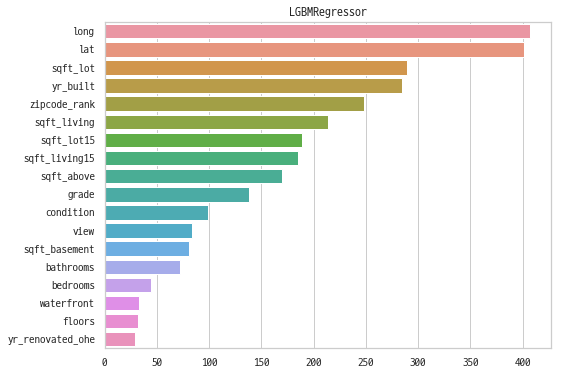

In [23]:
draw_importances(lightgbm, train)

- 큰 의미는 없는 것으로 확인

---

## \#SUBMISSION 5 : 3번 +`yr_renovated_ohe`

- renovated 된 집들만 년도 값을 가지고 아닌 집은 0값을 가졌던 `yr_renovated` 컬럼을 OHE 처리된 컬럼으로 사용해본다.

In [234]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated_ohe', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train = data[features]
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [236]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm]

In [237]:
%%time
row_scores = get_scores(models[3:], train, label)

CPU times: user 43.1 s, sys: 810 ms, total: 43.9 s
Wall time: 19.7 s


In [238]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1669,0.8995,117368.906974
GradientBoostingRegressor,0.1841,0.8777,136638.546082
XGBRegressor,0.1854,0.8759,178527.900646


In [239]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  127842.96704270385
R2 score:  0.8851893889234811


In [240]:
X_sub = test[features]

In [241]:
lightgbm.fit(train, label)
y_pred_5 = lightgbm.predict(X_sub)
y_pred_5

array([13.14103697, 13.08843713, 14.20486239, ..., 13.00760437,
       12.75123758, 12.96897859])

In [210]:
# submission = LetSubmit(np.expm1(y_pred), "logprice_lgbm_renovohe")
# submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 115033

- 역시 큰 의미는 없다

---

## \#SUBMISSION 6 : 3번 + `year_month`

- date를 나타내는 컬럼 중 `year_month` 컬럼 사용

In [345]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]

In [346]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [391]:
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm, rdforest]

In [392]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 43.2 s, sys: 1.15 s, total: 44.4 s
Wall time: 26.3 s


In [393]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1634,0.9033,121344.899765
XGBRegressor,0.1831,0.8786,131035.538895
GradientBoostingRegressor,0.1831,0.8785,125378.071093
RandomForestRegressor,0.1878,0.8739,120613.126149
LinearRegression,0.2510,0.7717,177622.786772
Ridge,0.2510,0.7717,182631.804389
Lasso,0.3586,0.5339,249896.050268


In [258]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  135540.73447376766
R2 score:  0.8916600798974885


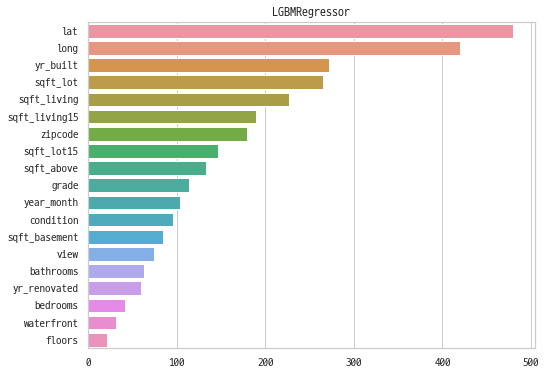

In [259]:
draw_importances(lightgbm, train)

In [279]:
X_sub = test[features]

In [261]:
lightgbm.fit(train, label)
y_pred_6 = lightgbm.predict(X_sub)
y_pred_6

array([13.11991712, 13.07210088, 14.13782266, ..., 13.00569581,
       12.67692089, 12.97785803])

In [262]:
submission = LetSubmit(np.expm1(y_pred_6), "logprice_lgbm_yearmonth")
submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 113112

- 크게 성능이 올랐다!

---

## \#SUBMISSION 7 : 6번 + `lat`, `long` outlier 삭제

- outlier를 삭제해본다.

In [350]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]

In [351]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [352]:
len(data[(data['long'] > -121.8) & (data['lat'] < 47.2)])

1

In [353]:
len(data[data['long'] > -121.6])

14

In [354]:
lat_long_outliers = list(data[(data['long'] > -121.8) & (data['lat'] < 47.2)].index)
lat_long_outliers.extend(list(data[data['long'] > -121.6].index))
lat_long_outliers

[2354,
 1853,
 2090,
 2988,
 4147,
 4298,
 7067,
 7607,
 9111,
 9237,
 9748,
 10199,
 11731,
 13668,
 13900]

- 15개의 outlier 삭제

In [355]:
print(train.shape, label.shape)
train = train.drop(lat_long_outliers)
label = label.drop(lat_long_outliers)
print(train.shape, label.shape)

(15035, 19) (15035,)
(15020, 19) (15020,)


In [356]:
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm]

In [357]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 32.6 s, sys: 869 ms, total: 33.5 s
Wall time: 18.7 s


In [358]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1642,0.9025,120390.273040
XGBRegressor,0.1831,0.8789,154117.671528
GradientBoostingRegressor,0.1831,0.8788,138327.155360
LinearRegression,0.2515,0.7713,175719.841444
Ridge,0.2515,0.7713,200553.535093
Lasso,0.3593,0.5332,520815.968358


In [333]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  110404.58014754365
R2 score:  0.8839848093132471


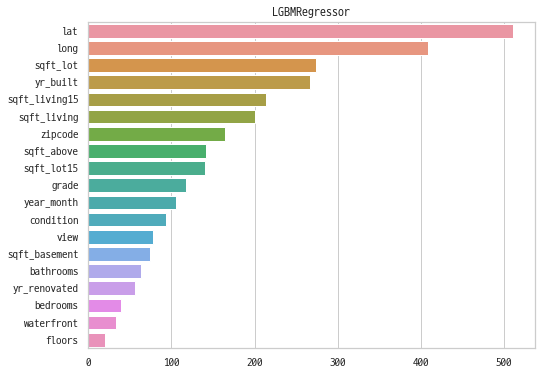

In [334]:
draw_importances(lightgbm, train)

In [335]:
X_sub = test[features]

In [336]:
lightgbm.fit(train, label)
y_pred_6 = lightgbm.predict(X_sub)
y_pred_6

array([13.13392358, 13.0232454 , 14.14707645, ..., 13.05463916,
       12.68275198, 12.95069427])

In [338]:
submission = LetSubmit(np.expm1(y_pred_6), "logprice_lgbm_latlongoutlier")
submission.head()

,id,price
0,15035,4.942906e+05
1,15036,4.744508e+05
2,15037,1.256917e+06
3,15038,3.068664e+05
4,15039,2.861011e+05


> Submission 결과 : 117716

- 큰 의미는 없다.

---

## \#SUBMISSION 8 : 6번 + `sqft_living`, `sqft_lot` outlier 삭제

- 면적 컬럼에 대한 outlier를 삭제 해본다.

In [359]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]

In [360]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [361]:
len(data[data['sqft_lot'] > 1250000])

1

In [362]:
len(data[data['sqft_living'] > 11000])

2

In [364]:
area_outliers = list(data[data['sqft_lot'] > 1250000].index)
area_outliers.extend(list(data[data['sqft_living'] > 11000].index))
area_outliers

[1231, 5108, 8912]

- 3개의 outlier 삭제

In [365]:
print(train.shape, label.shape)
train = train.drop(area_outliers)
label = label.drop(area_outliers)
print(train.shape, label.shape)

(15035, 19) (15035,)
(15032, 19) (15032,)


In [366]:
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm]

In [367]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 32.6 s, sys: 935 ms, total: 33.5 s
Wall time: 18.5 s


In [368]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1642,0.9025,107383.437272
GradientBoostingRegressor,0.1822,0.8800,131473.268107
XGBRegressor,0.1833,0.8785,133247.195640
LinearRegression,0.2516,0.7710,184454.769129
Ridge,0.2516,0.7710,182678.373287
Lasso,0.3587,0.5345,226737.940647


In [369]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  108229.45096238474
R2 score:  0.885204614392595


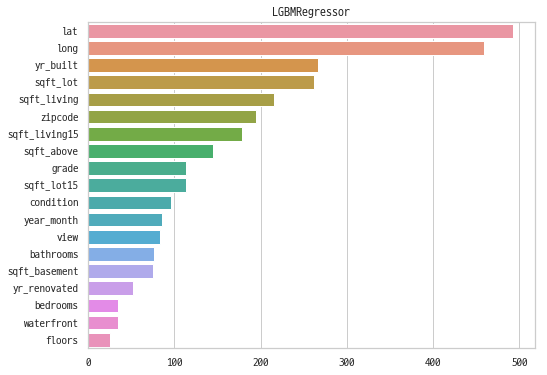

In [370]:
draw_importances(lightgbm, train)

---

## \#SUBMISSION 9 : 6번 + 7번 + 8번

In [377]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', \
            'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', \
            'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_month']

train = data[features]

In [378]:
data['log_price'] = np.log1p(data.price)
label = data['log_price']

In [379]:
lat_long_outliers = list(data[(data['long'] > -121.8) & (data['lat'] < 47.2)].index)
lat_long_outliers.extend(list(data[data['long'] > -121.6].index))
lat_long_outliers

[2354,
 1853,
 2090,
 2988,
 4147,
 4298,
 7067,
 7607,
 9111,
 9237,
 9748,
 10199,
 11731,
 13668,
 13900]

In [380]:
area_outliers = list(data[data['sqft_lot'] > 1250000].index)
area_outliers.extend(list(data[data['sqft_living'] > 11000].index))
area_outliers

[1231, 5108, 8912]

In [381]:
outliers = lat_long_outliers + area_outliers
len(outliers)

18

- 18개의 outlier 삭제

In [382]:
print(train.shape, label.shape)
train = train.drop(outliers)
label = label.drop(outliers)
print(train.shape, label.shape)

(15035, 19) (15035,)
(15017, 19) (15017,)


In [394]:
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [linear, ridge, lasso, gboost, xgboost, lightgbm, rdforest]

In [395]:
%%time
row_scores = get_scores(models, train, label)

CPU times: user 43.6 s, sys: 1.23 s, total: 44.9 s
Wall time: 26.9 s


In [396]:
row_scores

,RMSLE,R2 score,RMSE
LGBMRegressor,0.1634,0.9033,107509.885348
XGBRegressor,0.1831,0.8786,124879.325767
GradientBoostingRegressor,0.1831,0.8785,138652.191913
RandomForestRegressor,0.1877,0.8728,139874.332511
LinearRegression,0.2510,0.7717,182264.782125
Ridge,0.2510,0.7717,213561.370870
Lasso,0.3586,0.5339,225351.323897


In [369]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))
print("R2 score: ", r2_score(y_pred, y_test))

RMSE:  108229.45096238474
R2 score:  0.885204614392595


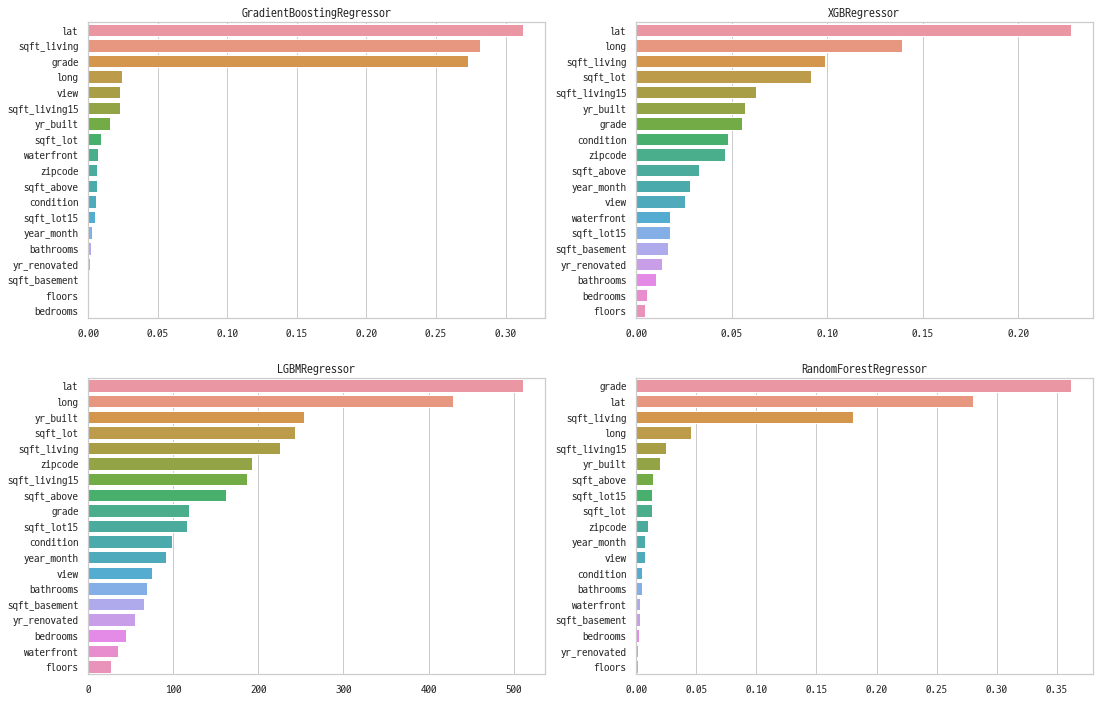

In [397]:
draw_importances(models[3:], train)